In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator, sample_data
from matplotlib import pyplot as plt
import numpy as np

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=80)
signal_generator.add_sinusoid1(a=2, omega=0.5, k=1.5)
signal_generator.add_sinusoid2(a=3, omega=2.5, c=1.5, k=0.5)
signal_generator.add_sinusoid2(a=3, omega=5, c=-1.5, k=0.5)
signal_generator.add_noise(random_seed=42)

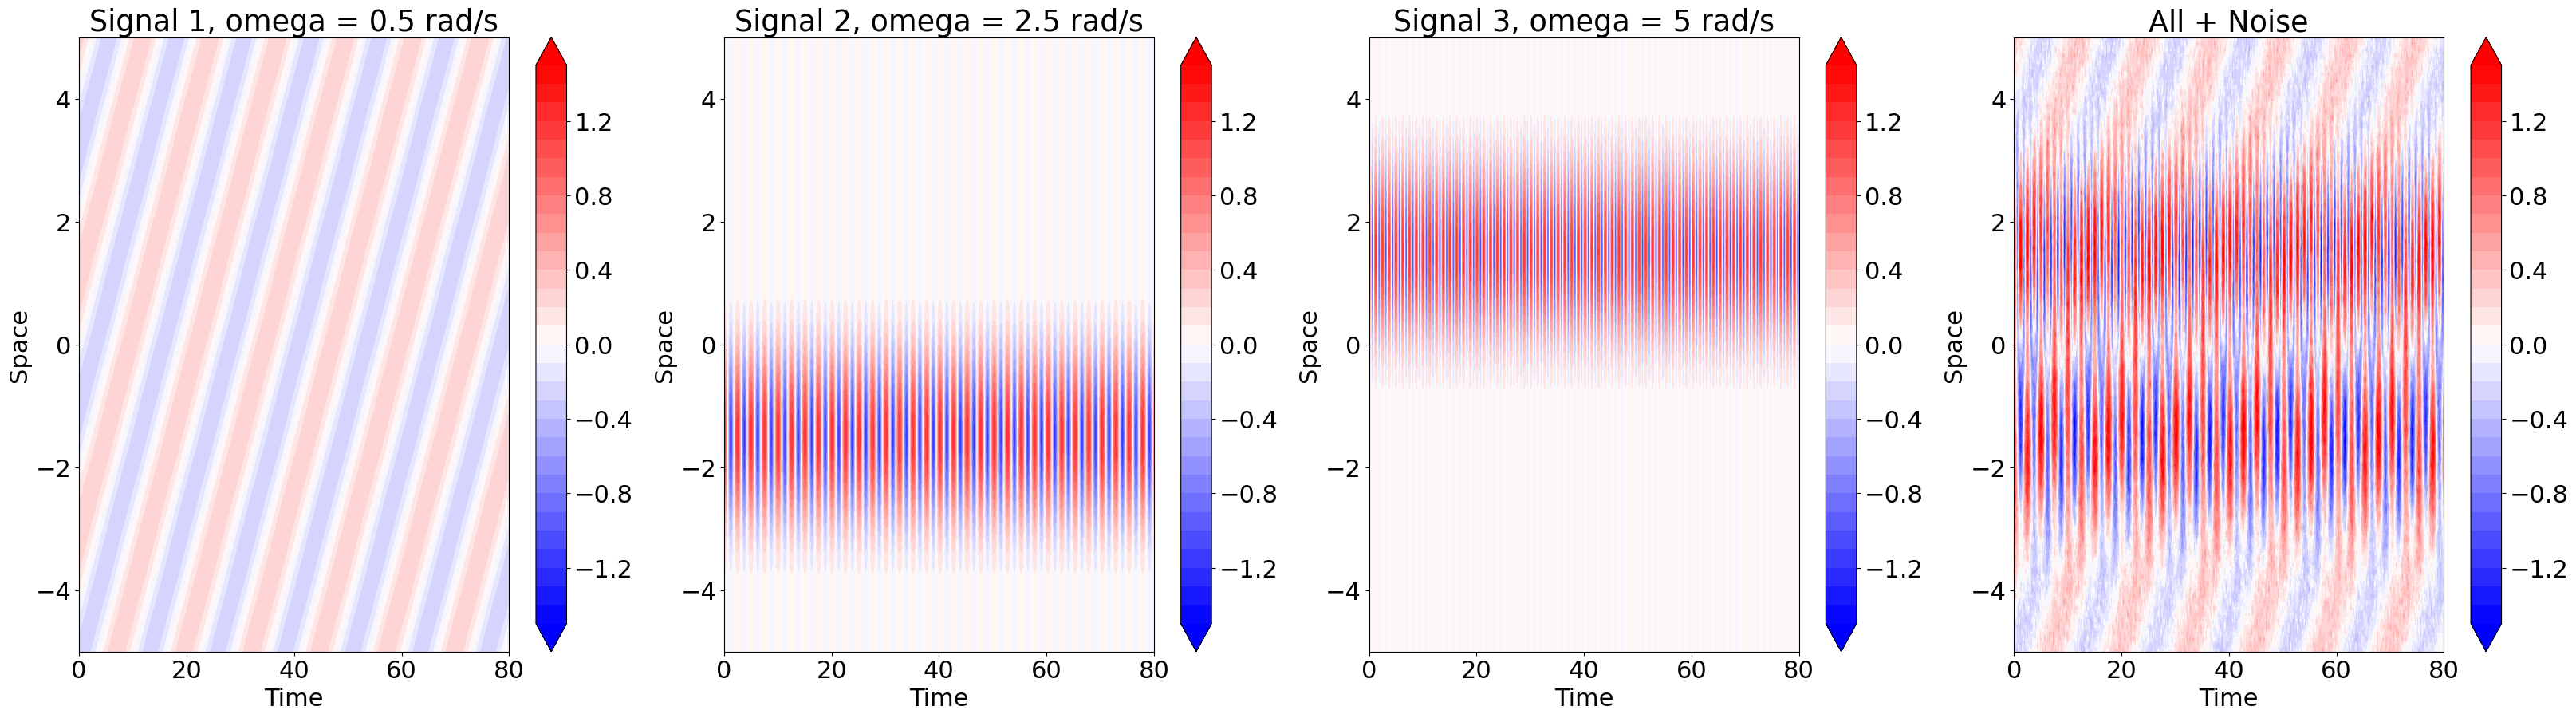

In [3]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 4, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 3)
contour = ax.contourf(
    signal_generator.T, signal_generator.X, signal_generator.components[2]["signal"], levels=levels, cmap='bwr', extend='both'
    )
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, omega = {signal_generator.components[2]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

In [4]:
# save 30% of the data for testing the forecast
train_frac = 0.7
signal_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
signal_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

In [5]:
fast_data, t_fast = sample_data(signal_train, t_train, dt=1, duration=30)
medium_data, t_medium = sample_data(signal_train, t_train, dt=2, duration=100)
slow_data, t_slow = sample_data(signal_train, t_train, dt=12)

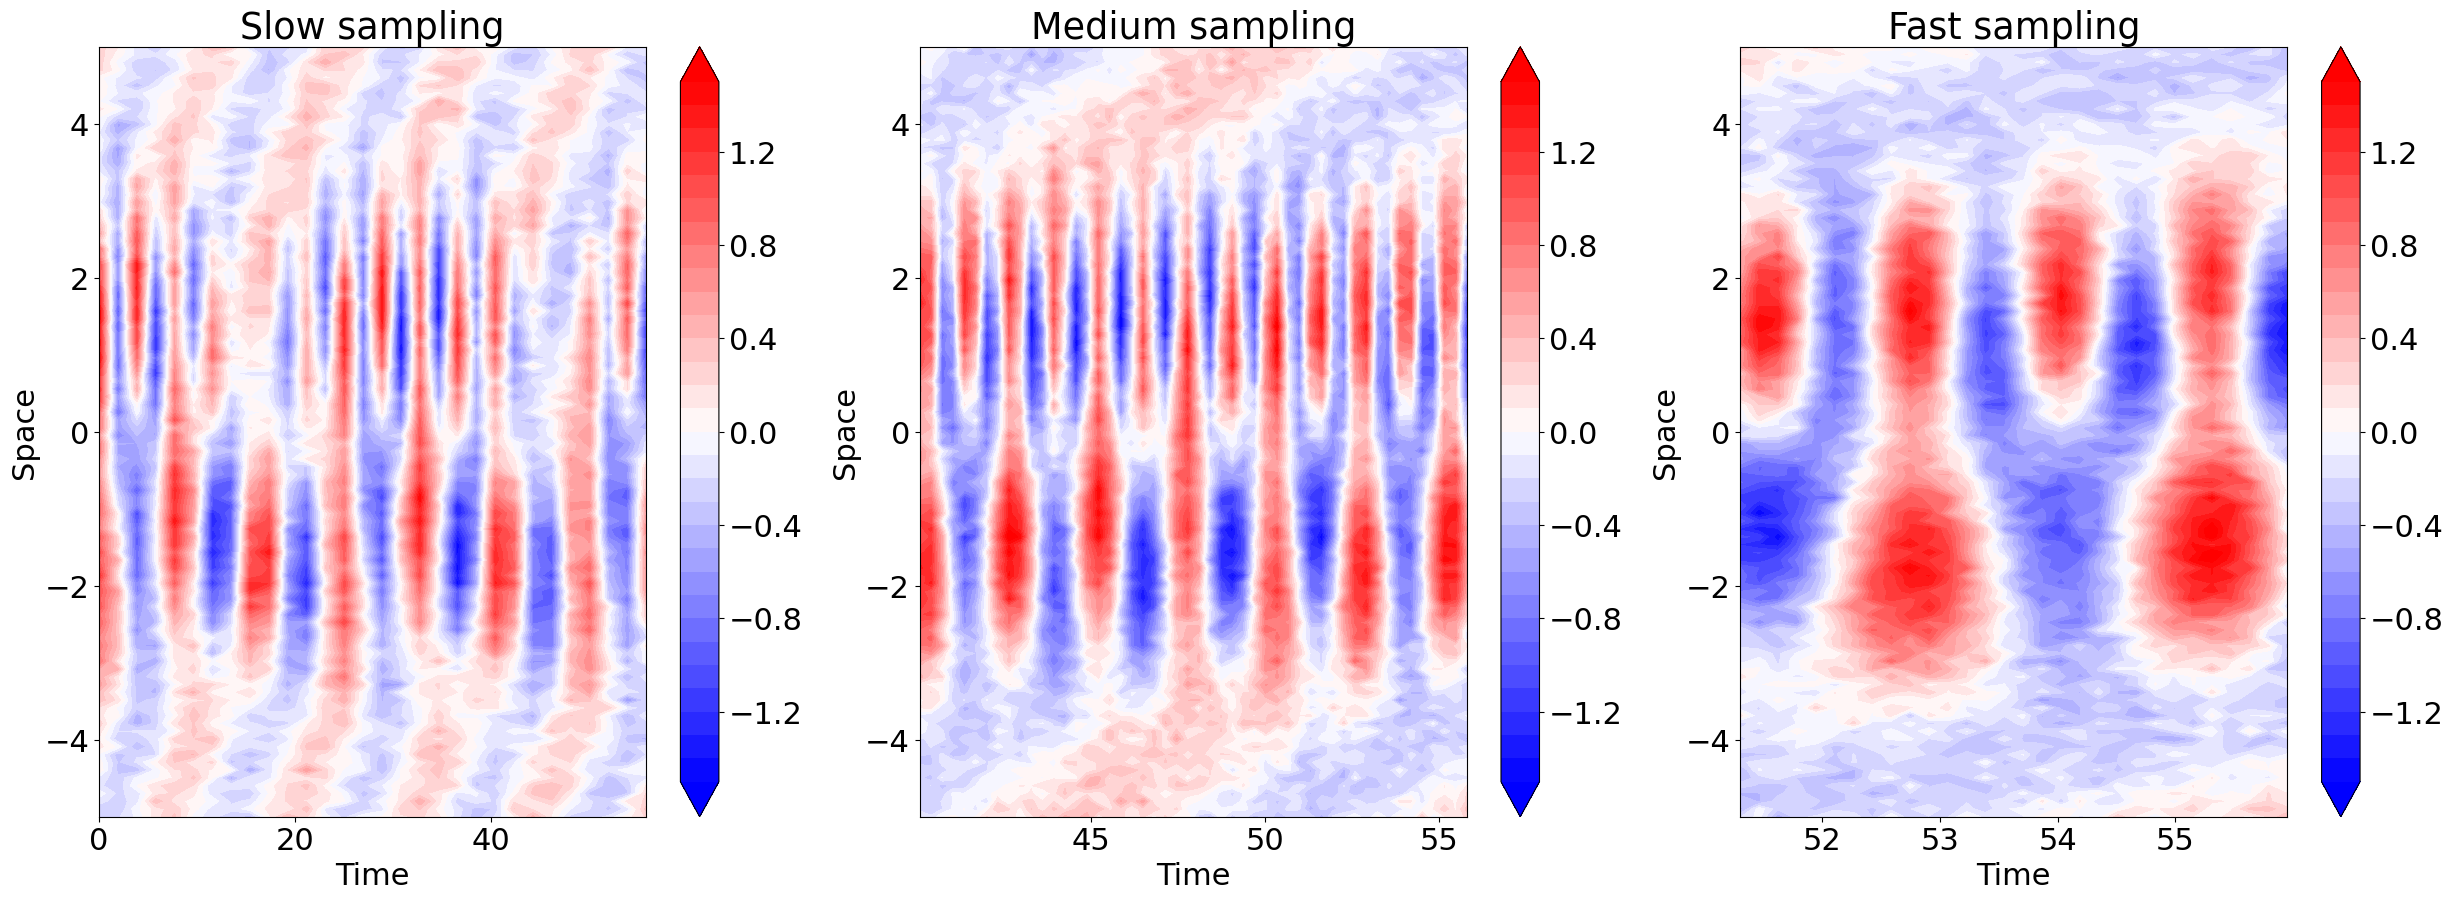

In [6]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(30, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
T, X = np.meshgrid(t_slow, signal_generator.x)
contour = ax.contourf(T, X, slow_data.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Slow sampling')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
T, X = np.meshgrid(t_medium, signal_generator.x)
contour = ax.contourf(T, X, medium_data.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Medium sampling')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
T, X = np.meshgrid(t_fast, signal_generator.x)
contour = ax.contourf(T, X, fast_data.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Fast sampling')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

DMD model on slow-sampled data

In [7]:
svd_rank=6
delay = 2

In [8]:
optdmd_slow = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=True, eig_constraints={"imag", "conjugate_pairs"})
delay_optdmd_slow = hankel_preprocessing(optdmd_slow, d=delay)

In [9]:
t_delay_slow = t_slow[:-delay+1]
delay_optdmd_slow.fit(slow_data.T, t=t_delay_slow)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


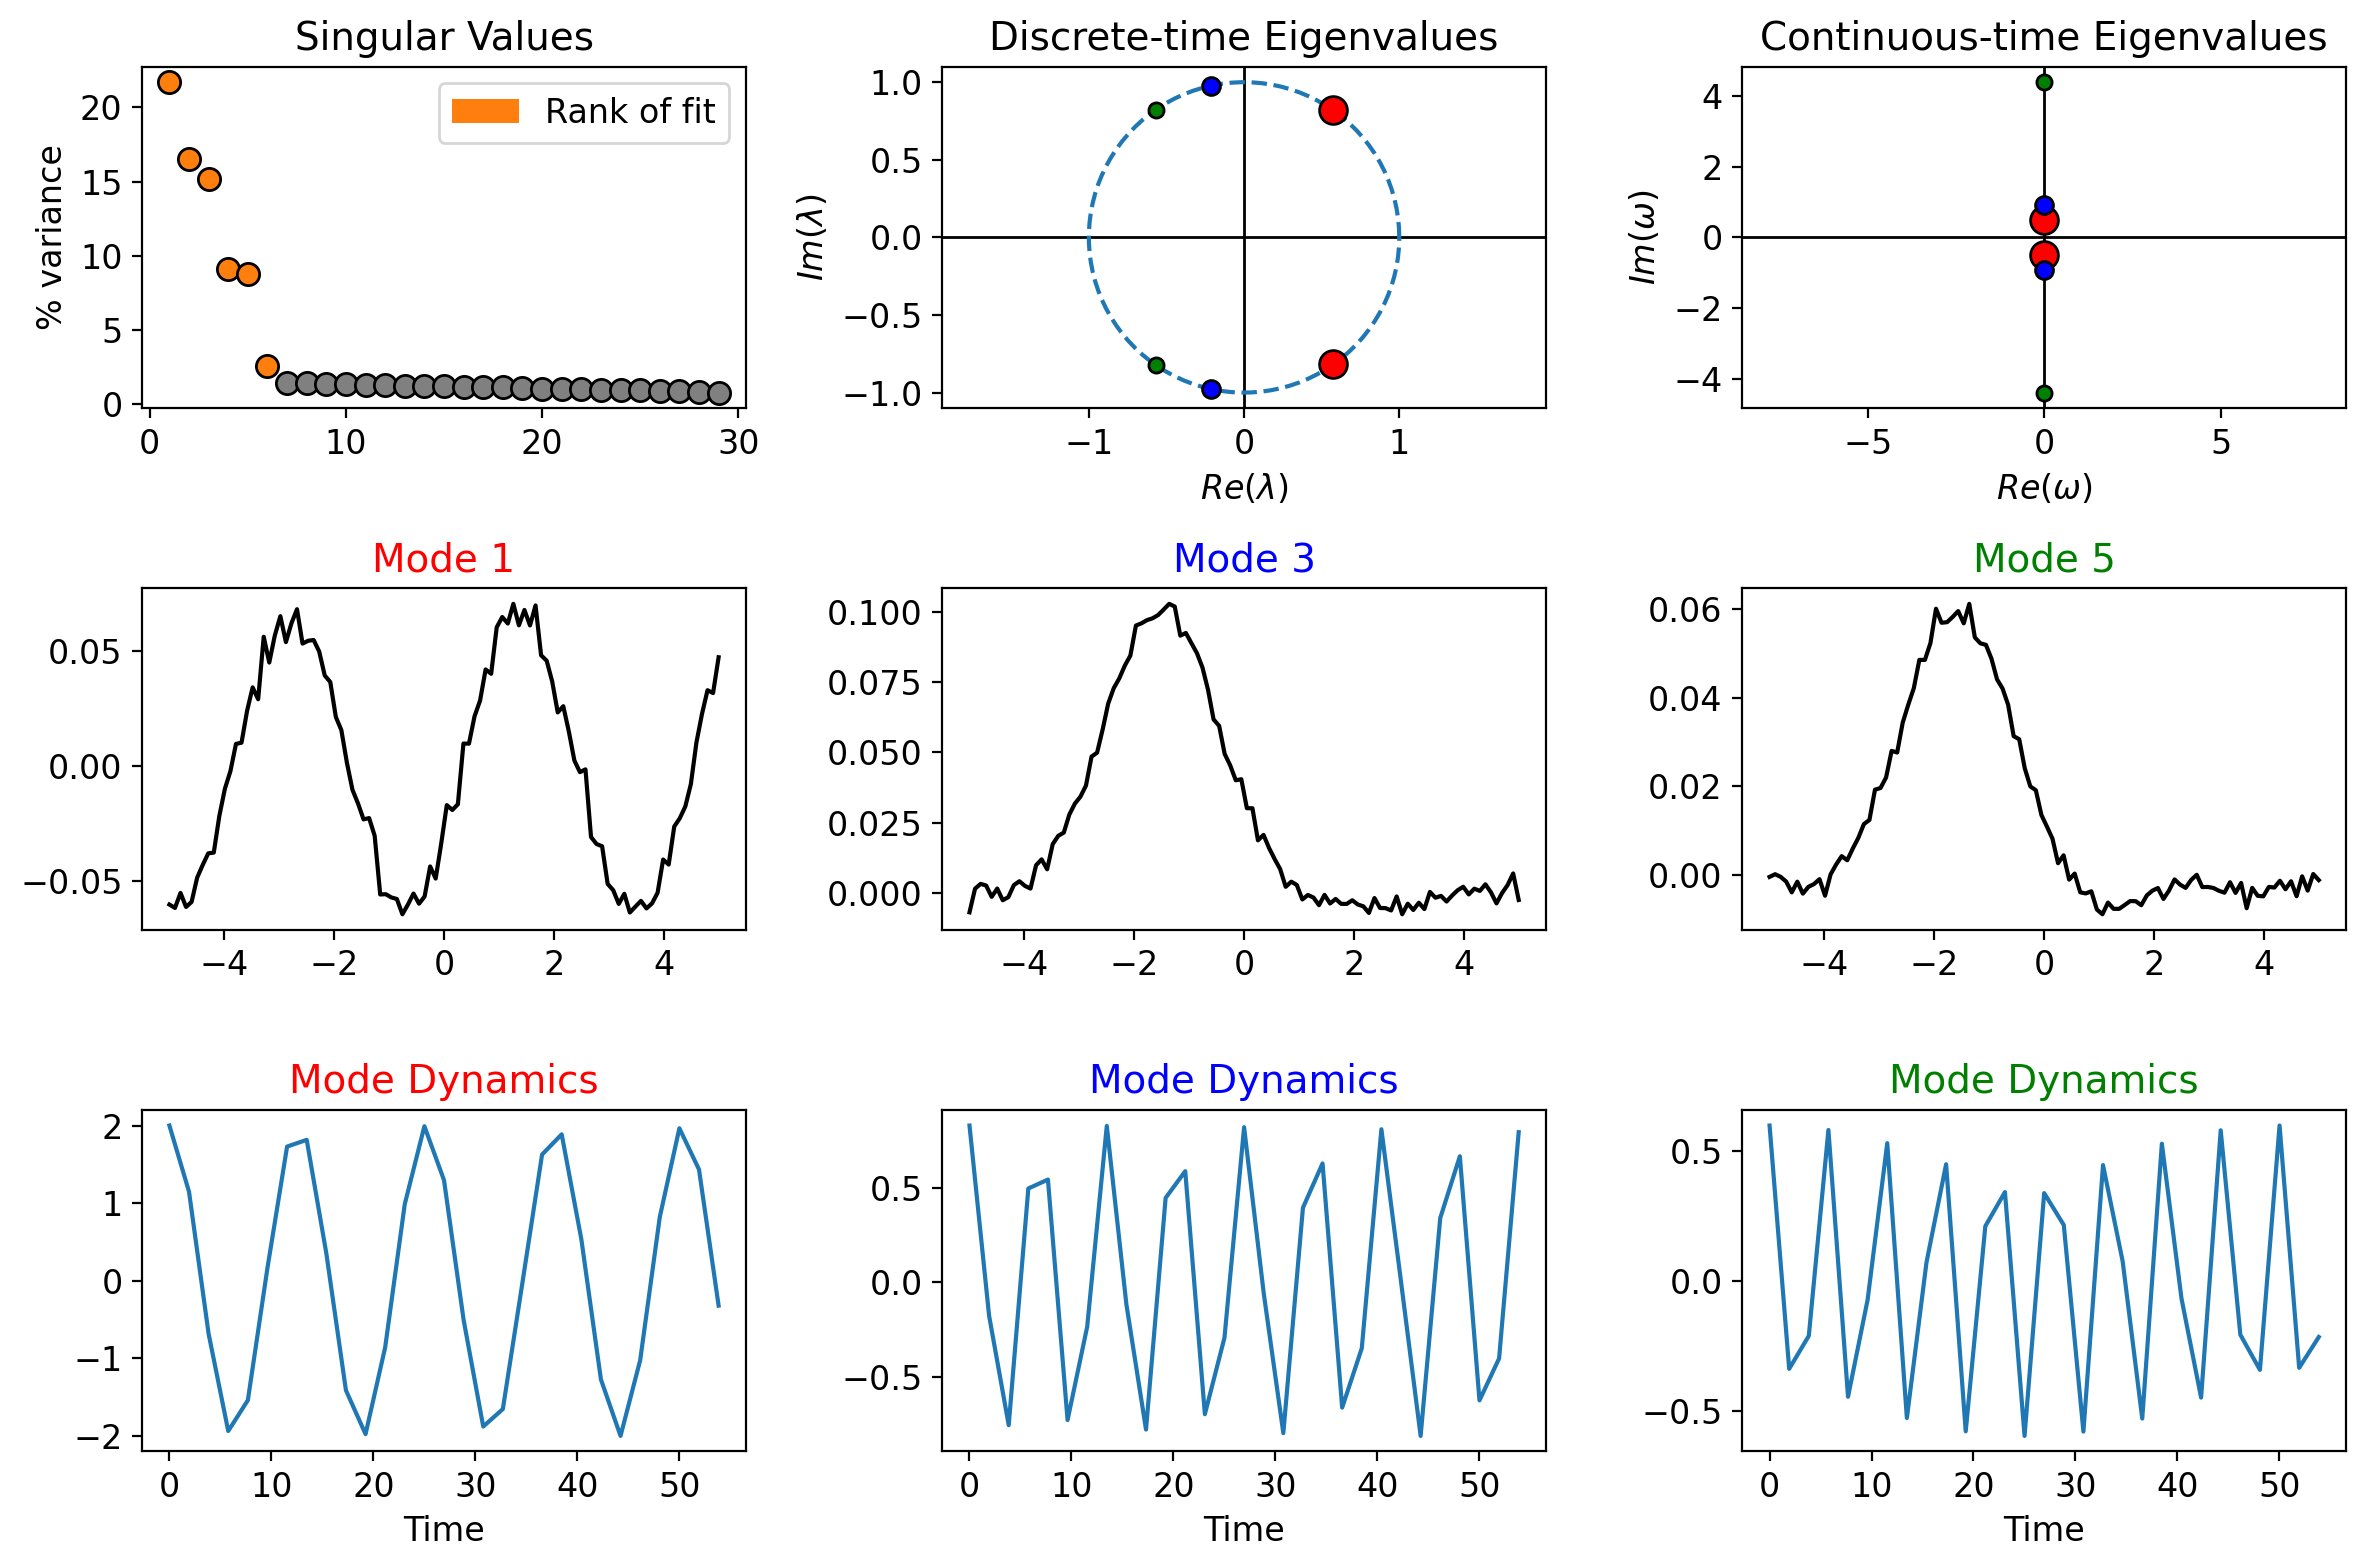

In [10]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd_slow, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [11]:
sorted_index_slow = np.argsort(delay_optdmd_slow.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd_slow.amplitudes[sorted_index_slow]}")
print(f"Eigenvalues: {delay_optdmd_slow.eigs[sorted_index_slow]}")

Amplitudes: [2.00436241 2.00436241 0.83000946 0.83000946 0.59700087 0.59700087]
Eigenvalues: [-0.-0.4986898j   0.+0.4986898j   0.+0.92770376j -0.-0.92770376j
  0.+4.39630786j -0.-4.39630786j]


DMD model on medium sampled data

In [12]:
svd_rank=6
delay = 2

In [13]:
optdmd_medium = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=True, eig_constraints={"imag", "conjugate_pairs"})
delay_optdmd_medium = hankel_preprocessing(optdmd_medium, d=delay)

In [14]:
t_delay_medium = t_medium[:-delay+1]
delay_optdmd_medium.fit(medium_data.T, t=t_delay_medium)

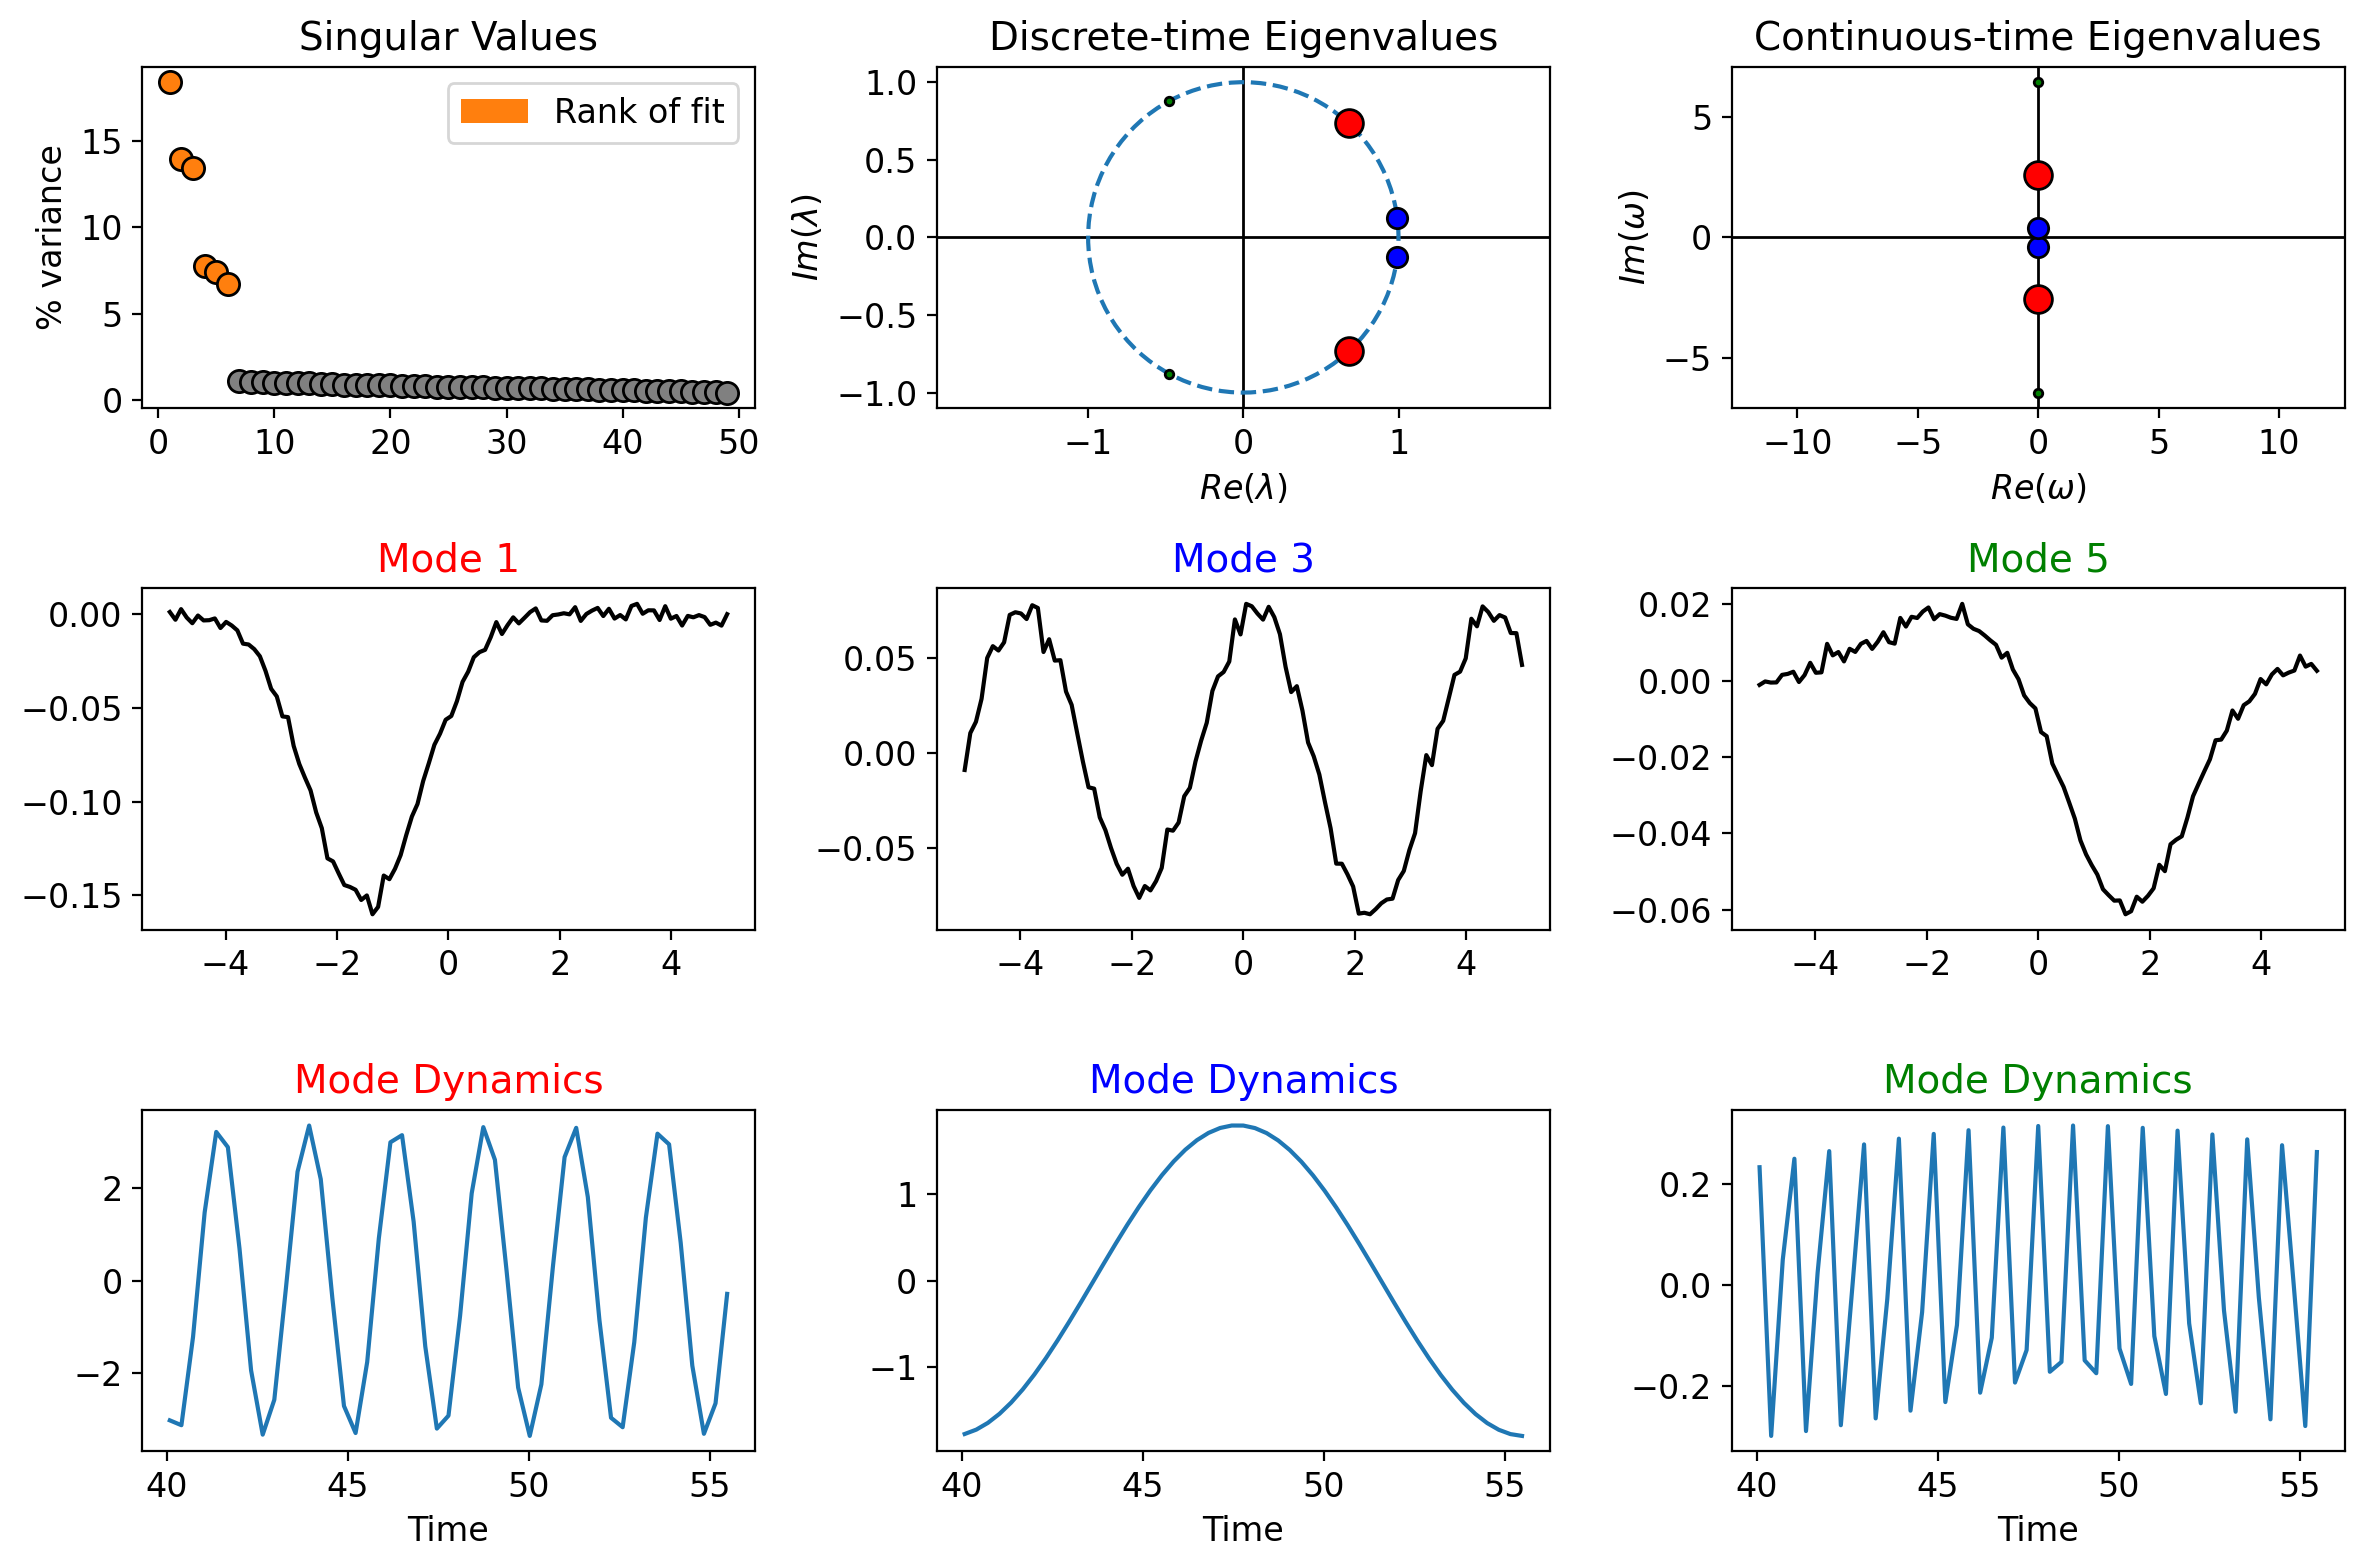

In [15]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd_medium, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [16]:
sorted_index_medium = np.argsort(delay_optdmd_medium.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd_medium.amplitudes[sorted_index_medium]}")
print(f"Eigenvalues: {delay_optdmd_medium.eigs[sorted_index_medium]}")

Amplitudes: [3.35572422 3.35572422 1.79994515 1.79994515 0.3151103  0.3151103 ]
Eigenvalues: [ 0.+2.57535562j -0.-2.57535562j -0.-0.39590917j  0.+0.39590917j
 -0.-6.44583695j  0.+6.44583695j]


DMD on fast sampled data

In [17]:
svd_rank=6
delay = 2

In [18]:
optdmd_fast = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=True, eig_constraints={"imag", "conjugate_pairs"})
delay_optdmd_fast = hankel_preprocessing(optdmd_fast, d=delay)

In [19]:
t_delay_fast = t_fast[:-delay+1]
delay_optdmd_fast.fit(fast_data.T, t=t_delay_fast)

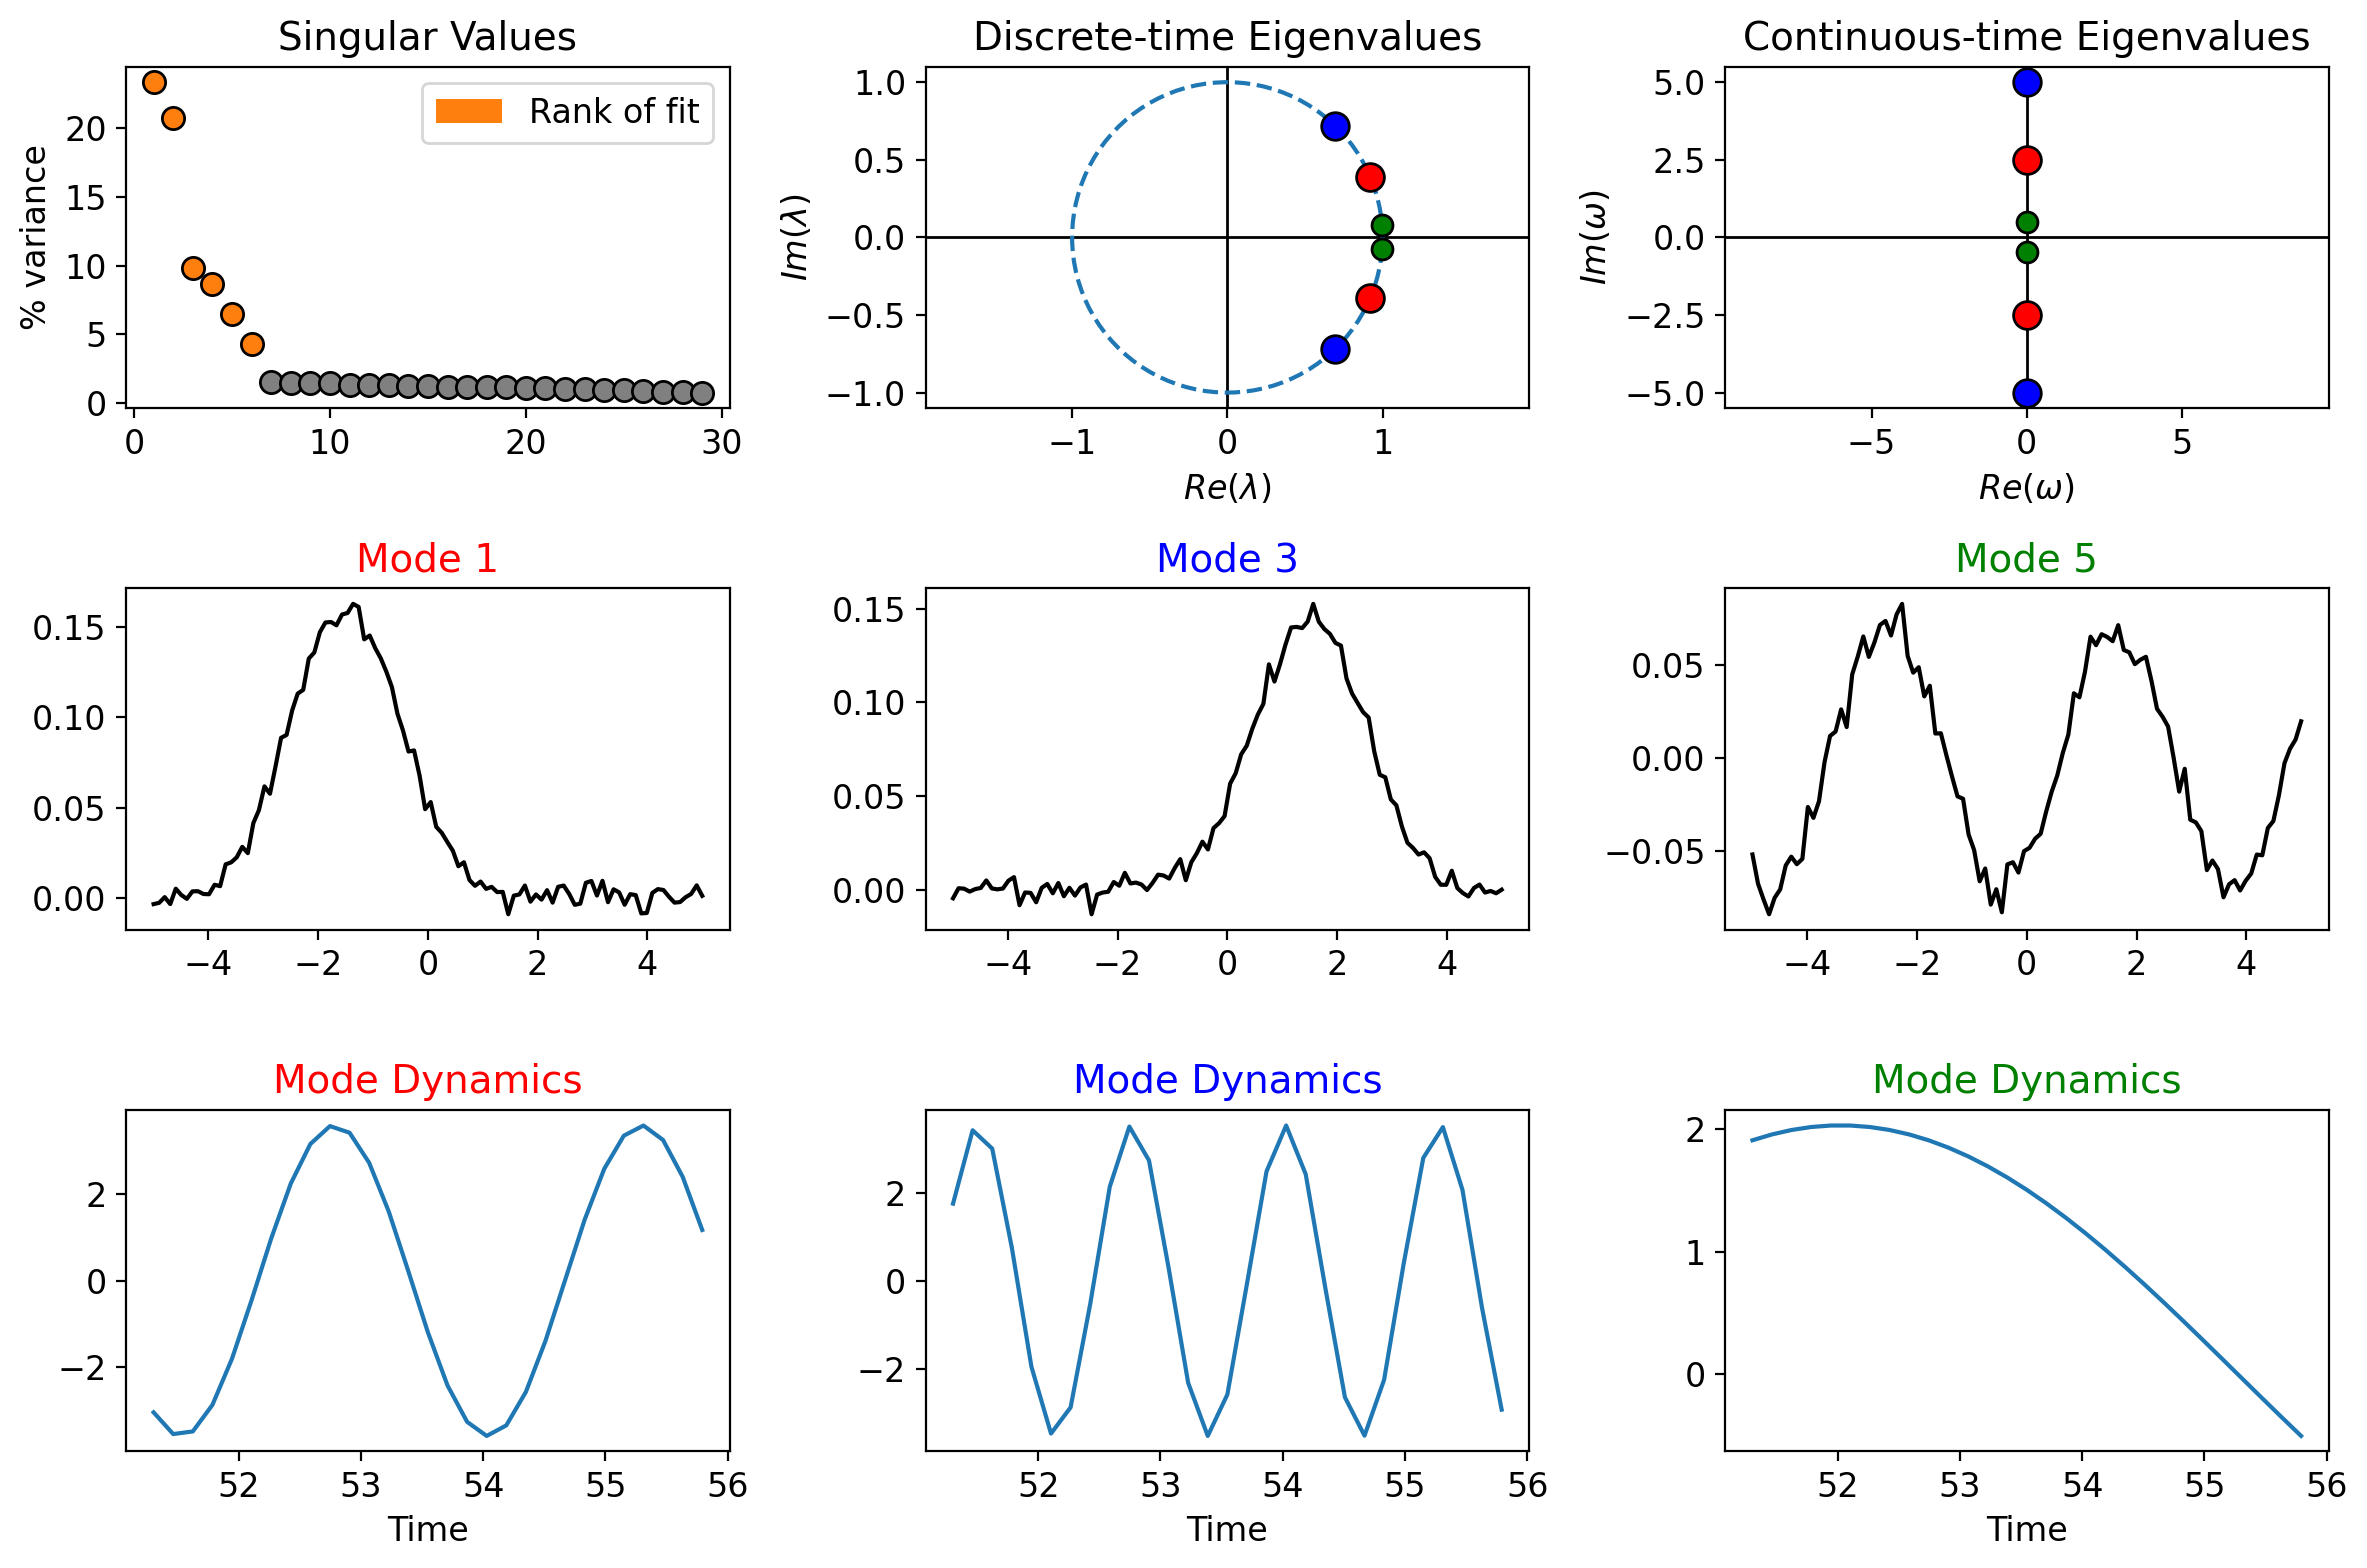

In [20]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd_fast, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [21]:
sorted_index_fast = np.argsort(delay_optdmd_fast.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd_fast.amplitudes[sorted_index_fast]}")
print(f"Eigenvalues: {delay_optdmd_fast.eigs[sorted_index_fast]}")

Amplitudes: [3.5844425  3.5844425  3.52770605 3.52770605 2.03022648 2.03022648]
Eigenvalues: [-0.-2.49980318j  0.+2.49980318j  0.+5.00091753j -0.-5.00091753j
 -0.-0.4831062j   0.+0.4831062j ]


In [22]:
def make_forecast(modes, amps, eigs, t):
    x = np.linalg.multi_dot(
            [
                modes,
                np.diag(amps),
                np.exp(np.outer(eigs, t)),
            ]
        )
    return x

Cherry-pick the modes from each DMD model:
- From slow DMD model we take modes 0 and 1
- From medium DMD model we take modes 0 and 1
- From fast DMD model we take modes 2 and 3

In [23]:
# slow
modes = delay_optdmd_slow.modes[:, sorted_index_slow[:2]]
amps = delay_optdmd_slow.amplitudes[sorted_index_slow[:2]]
eigs = delay_optdmd_slow.eigs[sorted_index_slow[:2]]

# medium
modes = np.column_stack((modes, delay_optdmd_medium.modes[:, sorted_index_medium[:2]]))
amps = np.append(amps, delay_optdmd_medium.amplitudes[sorted_index_medium[:2]])
eigs = np.append(eigs, delay_optdmd_medium.eigs[sorted_index_medium[:2]])

# fast
modes = np.column_stack((modes, delay_optdmd_fast.modes[:, sorted_index_fast[2:4]]))
amps = np.append(amps, delay_optdmd_fast.amplitudes[sorted_index_fast[2:4]])
eigs = np.append(eigs, delay_optdmd_fast.eigs[sorted_index_fast[2:4]])


In [24]:
forecast = make_forecast(modes, amps, eigs, t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

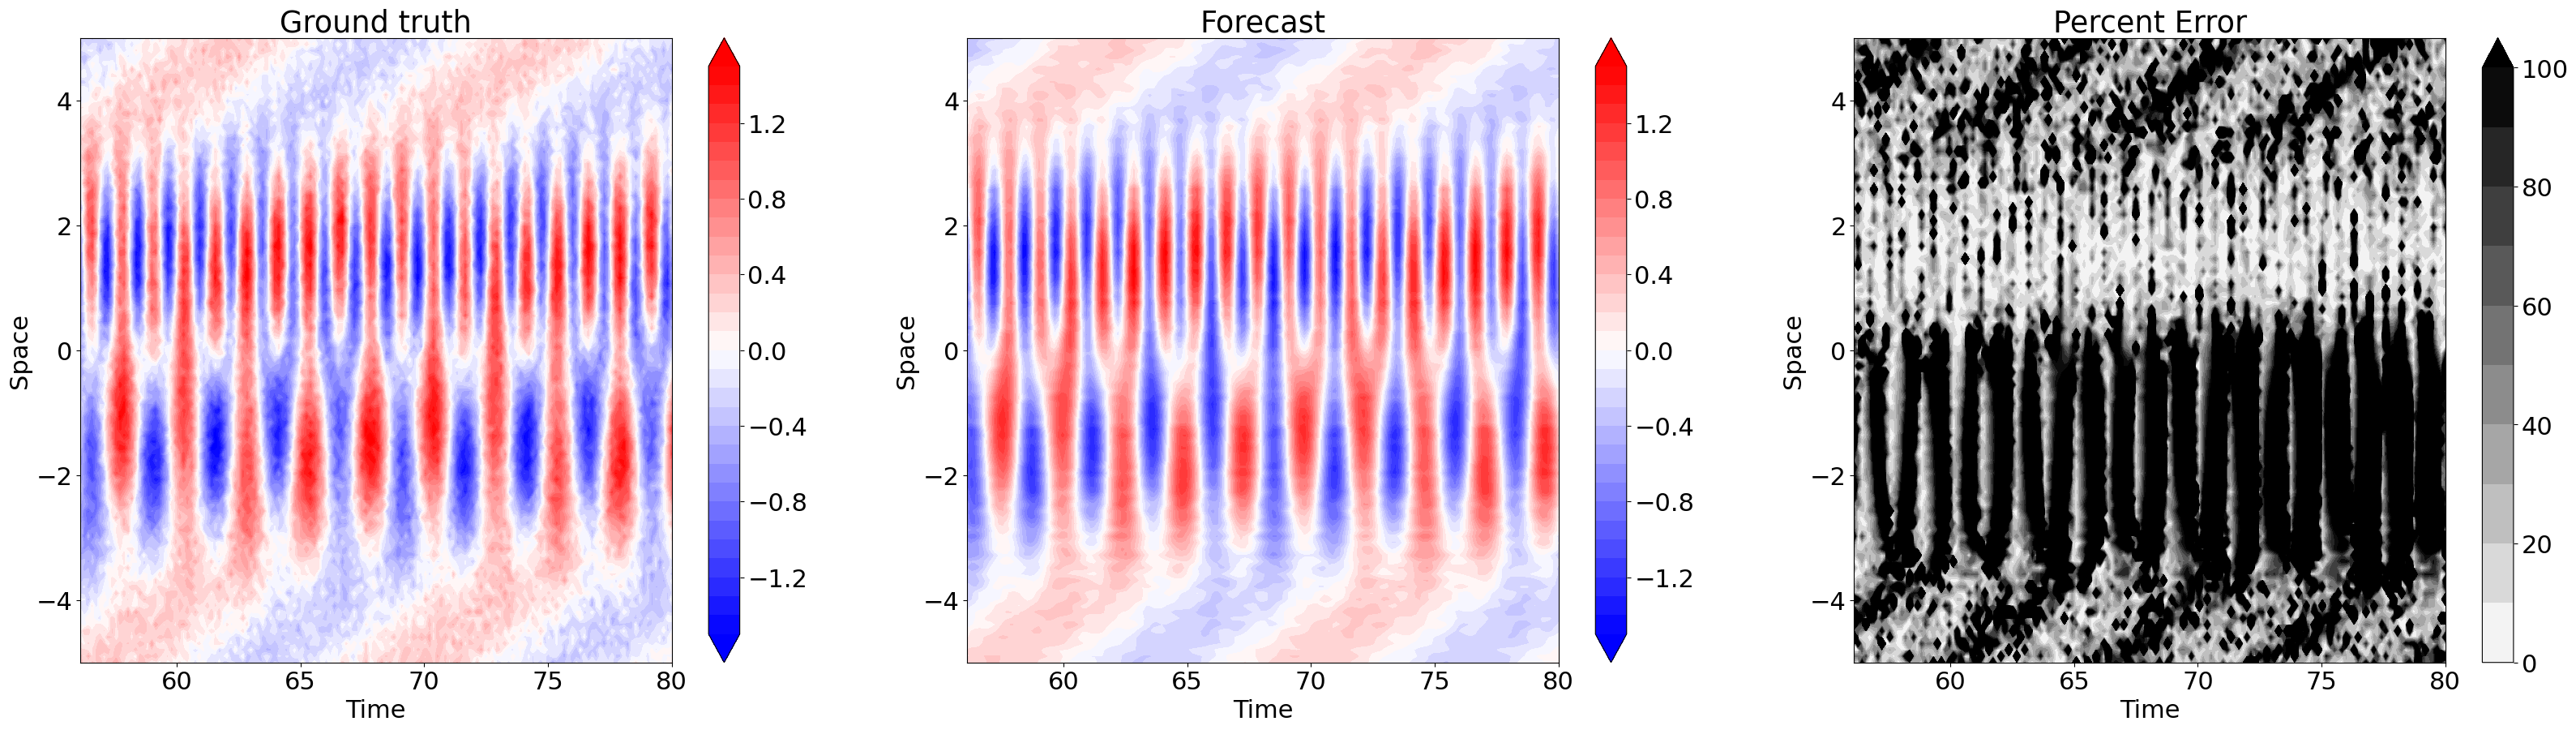

In [25]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, signal_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(signal_test - forecast) / np.abs(signal_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()